In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [3]:
data = np.load('./olivetti-faces/olivetti_faces.npy')
target = np.load('./olivetti-faces/olivetti_faces_target.npy')


#### Data verification 

In [4]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[0.30991736 0.3677686  0.41735536 0.44214877]


In [5]:
def show_40_distinct_people(images, unique_ids):
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

In [6]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols=10# each subject has 10 distinct face images
    rows=(len(subject_ids)*10)/cols #
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    #axarr=axarr.flatten()
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))

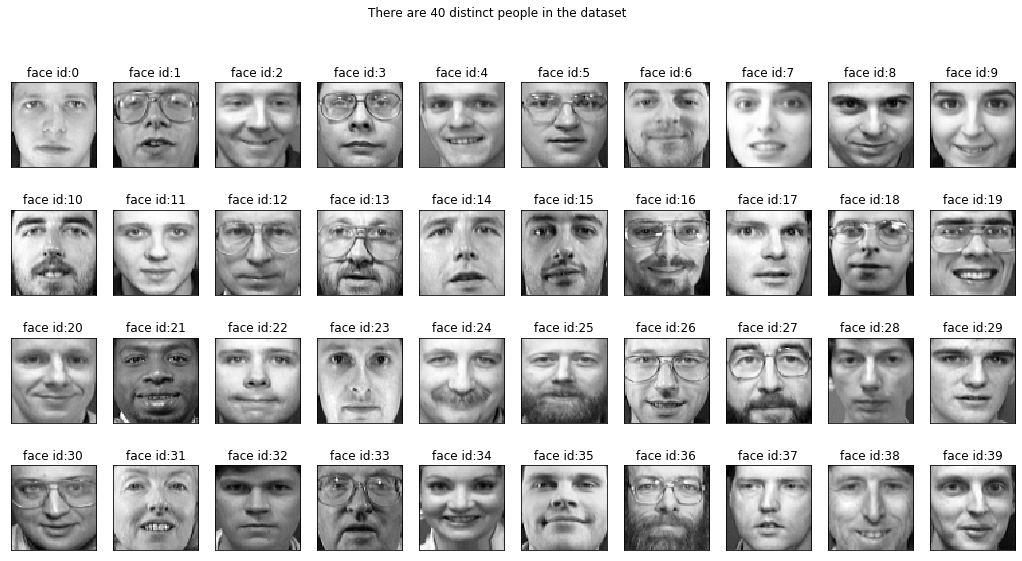

In [7]:
show_40_distinct_people(data, np.unique(target))


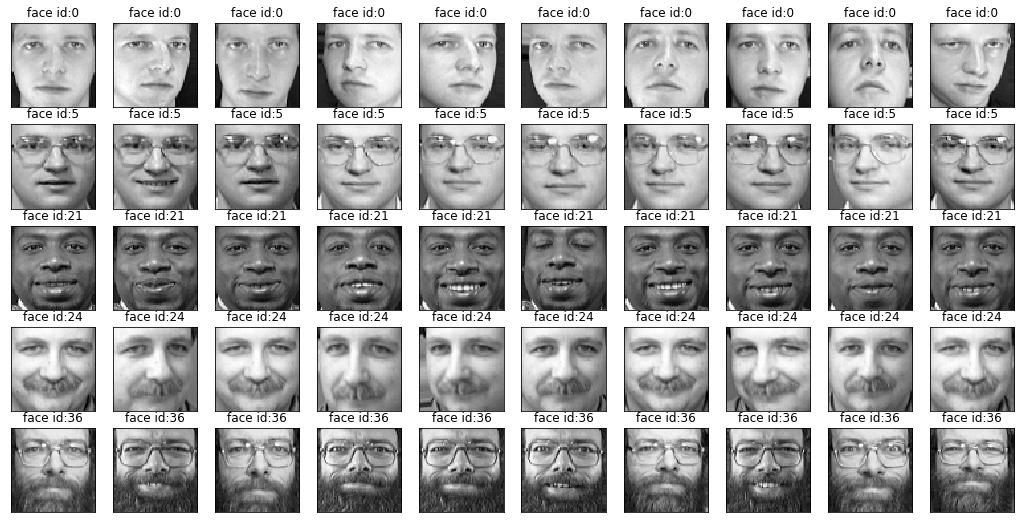

In [8]:
show_10_faces_of_n_subject(images=data, subject_ids=[0,5, 21, 24, 36])


In [9]:
N = 10  
data = data[0:N*10].reshape(N*10,-1) 
arr = np.arange(N*10)

#### Train - test split

In [10]:
X_train = data[arr%10 < 6]
X_test = data[arr%10 >= 6]

In [11]:
mean = np.mean(X_train,axis=0)
X_train = X_train - mean

In [12]:
cov_mat = (X_train @ X_train.T)/X_train.shape[1]
eigen_val,eigen_vec = np.linalg.eig(cov_mat)
eig_dict = dict(zip(eigen_val,eigen_vec))

In [13]:
comp_no = 50         
feature_vec = np.zeros((comp_no,X_train.shape[0]))
for n,i in enumerate(sorted(eig_dict,reverse=True)):
    if (n <comp_no):
        feature_vec[n] += eig_dict[i]

eigen_faces = feature_vec @ X_train

sign_faces = eigen_faces @ X_train.T


In [14]:
img_class = {}
for a in range(10):
    img_class[a]=((sign_faces.T)[a*6:(a+1)*6,:])

mean_class = np.array([np.mean(img_class[i],axis = 0) for i in sorted(img_class)])
mean_proj =  np.mean(sign_faces.T,axis = 0)

cov_within_class = {}
for a in sorted(img_class):
    temp1 = img_class[a] - mean_class[a]
    cov_within_class[a] = temp1.T @ temp1

SW = np.zeros(cov_within_class[0].shape)

for a in sorted(cov_within_class):
    SW += cov_within_class[a]

SB = np.zeros(SW.shape)
for a in sorted(img_class):
    temp2 = (mean_class[a] - mean_proj)
    SB += (temp2.T @ temp2)



J = (np.linalg.inv(SW)) @ SB

eig_val,eig_vec = np.linalg.eig(J)

lda_no = 30        # number of LDA components

order = np.flip(np.argsort(eig_val))
eig_vec = eig_vec[order]
best_featc = np.real(eig_vec[:lda_no])

fisher_faces = best_featc @ sign_faces


temp = np.arange(N)


temp = np.repeat(temp,4)
X_test1 = np.column_stack((temp,X_test))
np.random.shuffle(X_test1)

Y = (X_test1.T)[0]
X_test1 = X_test1[:,1:]

pred_y = np.zeros(X_test1.shape[0])


#for LDA and PCA 
for n,img in enumerate(X_test1):
    proj = eigen_faces @ (img - mean).T
    fisher_proj = best_featc @ proj
    dist = (fisher_proj - fisher_faces.T)
    dist = np.linalg.norm(dist.T,axis = 0)
    index = np.argmin(dist)
    pred_y[n] = np.floor(index/6)

In [15]:
print("Using Euclidean:", 1 - accuracy_score(Y,pred_y))

Using Euclidean: 0.625
